# In this notebook we explore the influnce of different ways of masking CTCF motis to the prediction score and success time.

There are three ways to go about this (in brackets are corresponding tags);
- just randomly shuffle the whole seq i.e no masking (all random)
- scan for CTCF and randomly shuffle the motifs (random motif masking)
- scan for CTCF and manually shuffle the motifs (manual motif masking)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import bioframe 
import pandas as pd
import numpy as np 
import os
import json
from io import StringIO
import seaborn as sns
import random 
import akita_utils 
from akita_utils.background_utils import mutation_search
import pysam
import time 
import h5py
genome_fasta = '/project/fudenber_735/genomes/mm10/mm10.fa'
genome_open = pysam.Fastafile('/project/fudenber_735/genomes/mm10/mm10.fa')

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'
import tensorflow as tf
print(tf.__version__)

import pysam
from basenji import dataset, seqnn, dna_io,stream
head_i = 1 #mouse
model_num = 1 #which fold to use

base_dir = '/project/fudenber_735/tensorflow_models/akita/v2/models/'
model_dir = base_dir+"/f"+str(model_num)+"c0/train/"
model_file  = model_dir+'/model'+str(head_i)+'_best.h5'

params_file = model_dir+'/params.json'
with open(params_file) as params_open:
    params = json.load(params_open)
    params_model = params['model']
    params_train = params['train']
seq_length = params_model['seq_length']
params_model['verbose'] = False
seqnn_model = seqnn.SeqNN(params_model)
print('built')
seqnn_model.restore(model_file, head_i=head_i)
print('restored')

hic_diags = params_model['diagonal_offset']
try:
    target_crop = params_model['trunk'][-2]['cropping']
except:
    target_crop = params_model['target_crop']
target_length_cropped = int((seq_length//2048 - target_crop*2 - hic_diags)* ((seq_length//2048 - target_crop*2 - hic_diags) +1)/2) 
target_map_size = seq_length//2048  - target_crop*2 
triu_tup = np.triu_indices(target_map_size,2)
target_map_size, target_length_cropped, triu_tup[0].shape

2.4.1


2022-12-04 20:23:14.246424: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


built
restored


(512, 130305, (130305,))

# Fetching chromosome data to explore background creation

In [3]:
chromsizes = bioframe.read_chromsizes('/project/fudenber_735/tensorflow_models/akita/v2/data/mm10/sequences.bed')
dframe = pd.DataFrame(chromsizes)
dframe['end'] = dframe['length']+ 1310720
dframe = dframe.reset_index()
dframe.rename(columns = {'index' : 'chrom', 'length':'start'}, inplace = True)
df = bioframe.frac_gc(dframe, bioframe.load_fasta('/project/fudenber_735/genomes/mm10/mm10.fa'), return_input=True)

df

,chrom,start,end,GC
0,chr1,40415232,41725952,0.407777
1,chr1,42708992,44019712,0.424985
2,chr1,42053632,43364352,0.424847
3,chr1,41725952,43036672,0.411407
4,chr1,43036672,44347392,0.417725
...,...,...,...,...
6033,chrX,99241984,100552704,0.424162
6034,chrX,120532992,121843712,0.367963
6035,chrX,139360256,140670976,0.407839
6036,chrX,128737280,130048000,0.370827


In [4]:
# df.iloc[6][['chrom','start','end','GC']]
# plt.hist( df['GC'].values, 100);
# np.percentile(df['GC'].dropna().values, np.linspace(1,99,50))

# Generating a sample for down stream analysis basing on GC content

In [5]:
super_set = []
error = 0.001

for gc in np.percentile(df['GC'].dropna().values, np.linspace(1,99,50)):
    for i in range(df.shape[0]):
        if gc-error <= df['GC'].values[i] <= gc+error:
            super_set += [i]
            break

super_set = list(set(super_set)); print(f'Whole distribution: {super_set} \n')
sample_set = super_set[2:10]; print(f'Sampled datapoints: {sample_set}')
new_dataframe = df.iloc[[ind for ind in set(sample_set)]] 

Whole distribution: [0, 1, 3, 4, 6, 7, 8, 9, 10, 12, 13, 15, 16, 147, 19, 21, 22, 23, 24, 26, 28, 288, 33, 163, 35, 165, 38, 39, 171, 44, 45, 47, 303, 50, 567, 64, 65, 68, 329, 74, 77, 79, 85, 90, 102, 496, 119, 120, 122] 

Sampled datapoints: [3, 4, 6, 7, 8, 9, 10, 12]


# Focusing on the scores' distributions and time taken to obtain a success trial (with and without masking)

In [7]:
max_iters=10
batch_size=6
# score = 5500

scores_storage_random_masking, flat_seqs_random_masking = mutation_search(    seqnn_model=seqnn_model,
                                                    genome_fasta=genome_fasta,
                                                    seq_length=seq_length,
                                                    dataframe= new_dataframe,
                                                    max_iters=max_iters,
                                                    batch_size=batch_size,
                                                    masking=0,timing = True)

print('**********************************')

scores_storage_motif_masking, flat_seqs_motif_masking = mutation_search(     seqnn_model=seqnn_model,
                                                    genome_fasta=genome_fasta,
                                                    seq_length=seq_length,
                                                    dataframe= new_dataframe,
                                                    max_iters=max_iters,
                                                    batch_size=batch_size,
                                                    masking=1,timing = True)

print('**********************************')

scores_storage_all_random, flat_seqs_no_mask = mutation_search(        seqnn_model=seqnn_model,
                                                    genome_fasta=genome_fasta,
                                                    seq_length=seq_length,
                                                    dataframe= new_dataframe,
                                                    max_iters=max_iters,
                                                    batch_size=batch_size,timing = True)

2022-12-04 20:24:38.731562: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-04 20:24:38.732062: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz
/home1/kamulege/.conda/envs/basenji-gpu/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


**********************************
**********************************


# Visualizing scores' distribution

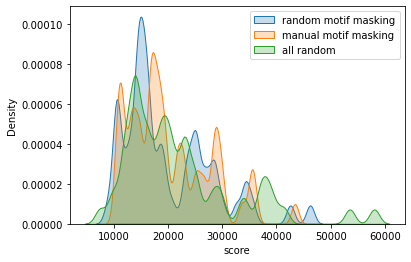

In [8]:
Y_1 = []
Y_2 = []
Y_3 = []

for i in scores_storage_random_masking:
    for j in scores_storage_random_masking[i]:
        Y_1 += j.tolist()

for i in scores_storage_motif_masking:
    for j in scores_storage_motif_masking[i]:
        Y_2 += j.tolist()        

for i in scores_storage_all_random:
    for j in scores_storage_all_random[i]:
        Y_3 += j.tolist()
        
# print(scores_storage_motif_masking)

kde_1 = pd.DataFrame(Y_1, columns=["score"])
kde_2 = pd.DataFrame(Y_2, columns=["score"])
kde_3 = pd.DataFrame(Y_3, columns=["score"])
sns.kdeplot(data=kde_1, x="score", bw_adjust=.2, label='random motif masking', fill=True)  
sns.kdeplot(data=kde_2, x="score", bw_adjust=.2, label='manual motif masking', fill=True)    
sns.kdeplot(data=kde_3, x="score", bw_adjust=.2, label='all random', fill=True)    
plt.legend()
plt.show()

# Visualizing time taken to obtain a success trial with masking

[63.85705828666687, 14.136460542678833, 79.89882063865662]


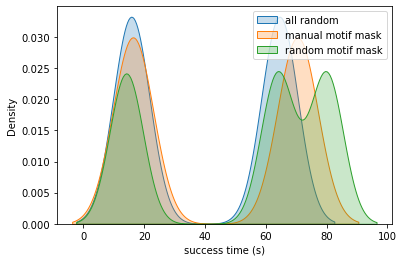

In [9]:
print(flat_seqs_motif_masking)

kde = pd.DataFrame(flat_seqs_no_mask, columns=["success time (s)"])    
sns.kdeplot(data=kde, x="success time (s)", bw_adjust=.2, label='all random', fill=True)    

kde = pd.DataFrame(flat_seqs_random_masking, columns=["success time (s)"])    
sns.kdeplot(data=kde, x="success time (s)", bw_adjust=.2, label='manual motif mask', fill=True)  

kde = pd.DataFrame(flat_seqs_motif_masking, columns=["success time (s)"])    
sns.kdeplot(data=kde, x="success time (s)", bw_adjust=.2, label='random motif mask', fill=True)  

plt.legend()
plt.show()